# KERNEL CLEAN

In [1]:
%reset -f -s

import gc

# LIBRARIES IMPORT

In [2]:
# imports

import CNN_lib
import CNN_utilities
import fig_lib 

import numpy as np
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report


In [3]:

trains_n=10
t_btw_frm=0.05

checking_on=False
data_augmentation= True

checkpoint_path = "C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/checkpoints"
pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/processed_train_d.pkl'   

In [4]:
check_points_p = [checkpoint_path+'_'+str(n)+'.h5' for n in range(trains_n)]

check_points_p

['C:/PROJECTS\\emboendo\\CNN\\python-machine-learning\\emboendo_ML\\embo_CNN_lab\\_static/checkpoints_0.h5',
 'C:/PROJECTS\\emboendo\\CNN\\python-machine-learning\\emboendo_ML\\embo_CNN_lab\\_static/checkpoints_1.h5',
 'C:/PROJECTS\\emboendo\\CNN\\python-machine-learning\\emboendo_ML\\embo_CNN_lab\\_static/checkpoints_2.h5',
 'C:/PROJECTS\\emboendo\\CNN\\python-machine-learning\\emboendo_ML\\embo_CNN_lab\\_static/checkpoints_3.h5',
 'C:/PROJECTS\\emboendo\\CNN\\python-machine-learning\\emboendo_ML\\embo_CNN_lab\\_static/checkpoints_4.h5',
 'C:/PROJECTS\\emboendo\\CNN\\python-machine-learning\\emboendo_ML\\embo_CNN_lab\\_static/checkpoints_5.h5',
 'C:/PROJECTS\\emboendo\\CNN\\python-machine-learning\\emboendo_ML\\embo_CNN_lab\\_static/checkpoints_6.h5',
 'C:/PROJECTS\\emboendo\\CNN\\python-machine-learning\\emboendo_ML\\embo_CNN_lab\\_static/checkpoints_7.h5',
 'C:/PROJECTS\\emboendo\\CNN\\python-machine-learning\\emboendo_ML\\embo_CNN_lab\\_static/checkpoints_8.h5',
 'C:/PROJECTS\\embo

# CNN

### GENERATE TRAIN DATA

In [5]:
# X_train,Y_train

with open(pkl_train_p, 'rb') as pikle_file:

    save_trains= pickle.load(pikle_file)

x_train,y_train,rcs =  save_trains[0],save_trains[1],save_trains[2]

max_frm_n, HEIGHT, WIDTH=np.shape(x_train)[1],np.shape(x_train)[2],np.shape(x_train)[3]


### CHECK 1

In [6]:
if checking_on:

    for x,y,r in zip(x_train,y_train,rcs):
        print(r,int(y),np.shape(x),type(x))

In [7]:
if checking_on:

    rec_elm='I70'
    idx=rcs.index(rec_elm)
    print(y_train[idx])

In [8]:
if checking_on:fig_lib.vid_show(x_train[idx],t_btw_frm=t_btw_frm)

In [9]:

Xx_train=x_train
Yy_train=y_train


## DATA SHUFFLE 1

In [10]:
Xx_train,Yy_train,recs=CNN_lib.shuffle(Xx_train,Yy_train,rcs)

## DATA SPLIT

In [11]:
test_size=0.2

X_train_spl, X_eval_spl, Y_train_spl, Y_eval_spl = train_test_split(Xx_train, Yy_train, test_size=test_size, shuffle=False) #,random_state=42)

recs_train =recs[0:len(Y_train_spl)]
recs_eval =recs[len(Y_train_spl)::]

print('Train data:',len(Y_train_spl),'Evaluation data:',len(Y_eval_spl))


Train data: 528 Evaluation data: 132


 Train data shape: (528, 40, 160, 160, 1)  Validation data shape: (132, 40, 160, 160, 1)


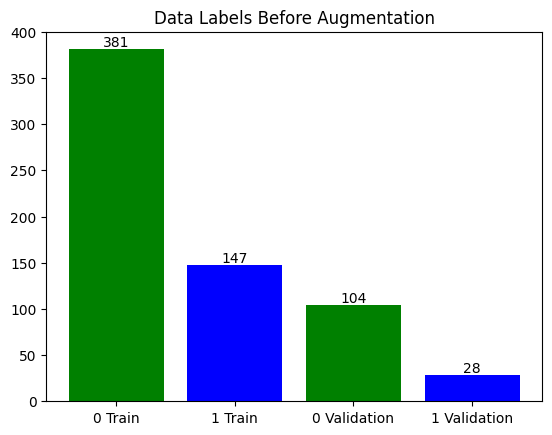

In [12]:
# check data

zeros_count = np.sum(Y_train_spl == 0)
ones_count = np.sum(Y_train_spl == 1)
zeros_count_val = np.sum(Y_eval_spl == 0)
ones_count_val = np.sum(Y_eval_spl == 1)

print(' Train data shape:', np.shape(X_train_spl),' Validation data shape:', np.shape(X_eval_spl))

CNN_lib.data_bars_plot(zeros_count,ones_count,zeros_count_val,ones_count_val)

# DATA AUGMENTATION

In [13]:
if data_augmentation:
    
    n_flip_1=1
    n_flip_0=0.07

    nf1 = round(n_flip_1*ones_count)
    nf0 = round(n_flip_0*zeros_count)

    print(f'Flip 1: {nf1}, 0: {nf0}')

    n_contr_1=0.4
    n_contr_0=0.04

    nc1 = round(n_contr_1*ones_count)
    nc0 = round(n_contr_0*zeros_count)

    print(f'Contrast 1: {nc1}, 0: {nc0}')

    n_bright_1=0.3
    n_bright_0=0.03

    nb1 = round(n_bright_1*ones_count)
    nb0 = round(n_bright_0*zeros_count)

    print(f'brightness 1: {nb1}, 0: {nb0}')



Flip 1: 147, 0: 27
Contrast 1: 59, 0: 15
brightness 1: 44, 0: 11


In [14]:

if data_augmentation:

    Flip_X_1,Flip_Y_1,Flip_recs_1=CNN_lib.main_aug_f(nf1,X_train_spl,Y_train_spl,recs,label=1,typ='Flip')
    Flip_X_0,Flip_Y_0,Flip_recs_0=CNN_lib.main_aug_f(nf0,X_train_spl,Y_train_spl,recs,label=0,typ='Flip')

    Cntr_X_1,Cntr_Y_1,Cntr_recs_1=CNN_lib.main_aug_f(nc1,X_train_spl,Y_train_spl,recs,label=1,typ='Contrast')
    Cntr_X_0,Cntr_Y_0,Cntr_recs_0=CNN_lib.main_aug_f(nc0,X_train_spl,Y_train_spl,recs,label=0,typ='Contrast')

    Bgr_X_1,Bgr_Y_1,Bgr_recs_1=CNN_lib.main_aug_f(nb1,X_train_spl,Y_train_spl,recs,label=1,typ='Brightness')
    Bgr_X_0,Bgr_Y_0,Bgr_recs_0=CNN_lib.main_aug_f(nb0,X_train_spl,Y_train_spl,recs,label=0,typ='Brightness')


In [15]:
if data_augmentation:

    X_train_spl = np.concatenate((X_train_spl, Flip_X_1,Flip_X_0,Cntr_X_1,Cntr_X_0,Bgr_X_1,Bgr_X_0), axis=0)
    Y_train_spl = np.concatenate((Y_train_spl, Flip_Y_1, Flip_Y_0,Cntr_Y_1,Cntr_Y_0,Bgr_Y_1,Bgr_Y_0))
    
    recs_train = recs_train+Flip_recs_1+Flip_recs_0+Cntr_recs_1+Cntr_recs_0+Bgr_recs_1+Bgr_recs_0

    print(X_train_spl.shape,Y_train_spl.shape)
    print(X_eval_spl.shape,Y_eval_spl.shape)


(831, 40, 160, 160, 1) (831,)
(132, 40, 160, 160, 1) (132,)


### DATA SHUFFLE 2

In [16]:
if data_augmentation: X_train,Y_train,recs_train_f=CNN_lib.shuffle(X_train_spl,Y_train_spl,recs_train)
else: X_train,Y_train,recs_train_f = X_train_spl,Y_train_spl,recs_train

X_eval=X_eval_spl
Y_eval=Y_eval_spl

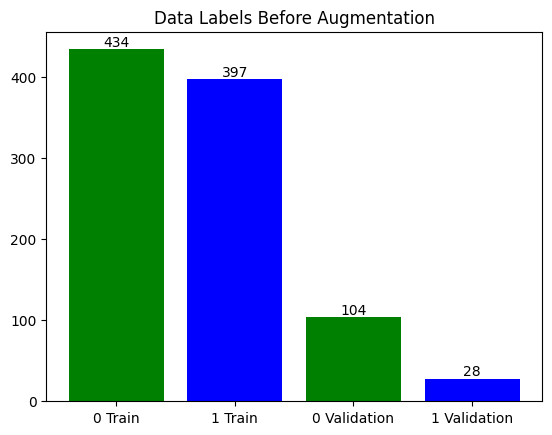

In [17]:
# check data
if data_augmentation:

    zeros_count = np.sum(Y_train == 0)
    ones_count = np.sum(Y_train == 1)
    zeros_count_val = np.sum(Y_eval == 0)
    ones_count_val = np.sum(Y_eval == 1)

    CNN_lib.data_bars_plot(zeros_count,ones_count,zeros_count_val,ones_count_val)

### CHECK 2

In [18]:
if checking_on:

    for x,y,r in zip(X_train,Y_train,recs_train_f):
        print(r,int(y),np.shape(x),type(x))
        

In [19]:

if checking_on:

    rec_elm='I180'
    idx=recs_train_f.index(rec_elm)
    print(idx,Y_train[idx])

In [20]:
if checking_on:fig_lib.vid_show(X_train[idx],t_btw_frm=t_btw_frm)

#  CNN

In [21]:
print('LIBRARY MODELS:')
print(' ')

for model_name in CNN_lib.MODELS.values(): print(model_name)

LIBRARY MODELS:
 
image_full
image_conv
image_conv_augmentation
video_conv2D
video_conv3D
conv3D_2D+1


In [22]:
# -------- CNN PARAMS --------

# -------- MODEL --------

model_from_CNN_lib,mdl= False,'video_conv3D'

opt='adam'
lss='binary_crossentropy'

# -------- TRAINNING --------

epochs=8


### MODEL

In [23]:
gc.collect()

5890

In [24]:
# MODEL 
input_shape=(max_frm_n, HEIGHT, WIDTH, 1)

modelos=[]

for _ in check_points_p:

  if model_from_CNN_lib: model = CNN_lib.lib_models(mdl,im_input_shp=input_shape)

  else:

    model = models.Sequential([
            layers.Conv3D(filters=16, kernel_size=(3, 3, 1), activation='relu',input_shape=input_shape),
            layers.MaxPooling3D(pool_size=(2, 2, 2)),
            layers.Conv3D(filters=32, kernel_size=(3, 3, 1),  activation='relu'),
            layers.MaxPooling3D(pool_size=(2, 2, 2)),
            layers.Conv3D(filters=32, kernel_size=(3, 3, 1),  activation='relu'),
            layers.MaxPooling3D(pool_size=(2, 2, 2)),
            layers.Conv3D(filters=16, kernel_size=(1, 1, 5),  activation='relu'),
            layers.Flatten(),
            layers.Dropout(0.2),
            layers.Dense(64, activation='relu'),
            layers.Dense(1,activation='sigmoid')
            ])
    
  model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])
  modelos.append(model)

model.summary()



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 38, 158, 160, 16   160       
                             )                                   
                                                                 
 max_pooling3d_27 (MaxPooli  (None, 19, 79, 80, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_37 (Conv3D)          (None, 17, 77, 80, 32)    4640      
                                                                 
 max_pooling3d_28 (MaxPooli  (None, 8, 38, 40, 32)     0         
 ng3D)                                                           
                                                                 
 conv3d_38 (Conv3D)          (None, 6, 36, 40, 32)     9248      
                                                    

In [25]:
checkpoints=[ModelCheckpoint(pp, save_best_only=True, monitor='val_loss',   mode='min', verbose=1) for pp in check_points_p]


### TRAINNING

In [26]:
histories=[md.fit(X_train, Y_train, epochs=epochs, validation_data=(X_eval,Y_eval),callbacks=[chk_p]) for md, chk_p in zip(modelos,checkpoints)]

Epoch 1/8


26/26 [==============================] - ETA: 0s - loss: 0.6994 - accuracy: 0.5150
Epoch 1: val_loss improved from inf to 0.68896, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\checkpoints_0.h5
26/26 [==============================] - 14s 520ms/step - loss: 0.6994 - accuracy: 0.5150 - val_loss: 0.6890 - val_accuracy: 0.7879
Epoch 2/8


c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - ETA: 0s - loss: 0.6880 - accuracy: 0.5620
Epoch 2: val_loss improved from 0.68896 to 0.68533, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\checkpoints_0.h5
26/26 [==============================] - 13s 508ms/step - loss: 0.6880 - accuracy: 0.5620 - val_loss: 0.6853 - val_accuracy: 0.6742
Epoch 3/8
26/26 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.5993
Epoch 3: val_loss improved from 0.68533 to 0.62068, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\checkpoints_0.h5
26/26 [==============================] - 13s 507ms/step - loss: 0.6562 - accuracy: 0.5993 - val_loss: 0.6207 - val_accuracy: 0.6894
Epoch 4/8
26/26 [==============================] - ETA: 0s - loss: 0.5934 - accuracy: 0.6847
Epoch 4: val_loss did not improve from 0.62068
26/26 [==============================] - 13s 517ms/step - loss: 0.5934 - accuracy: 0.6

### EVALUATE MODEL

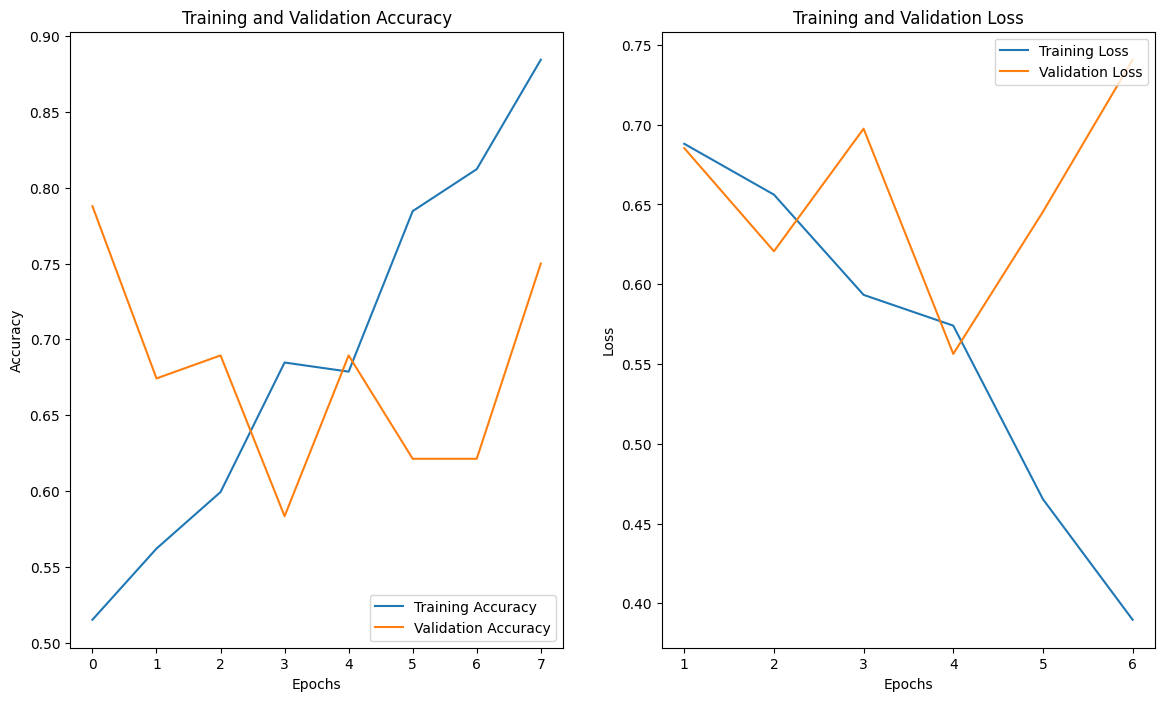

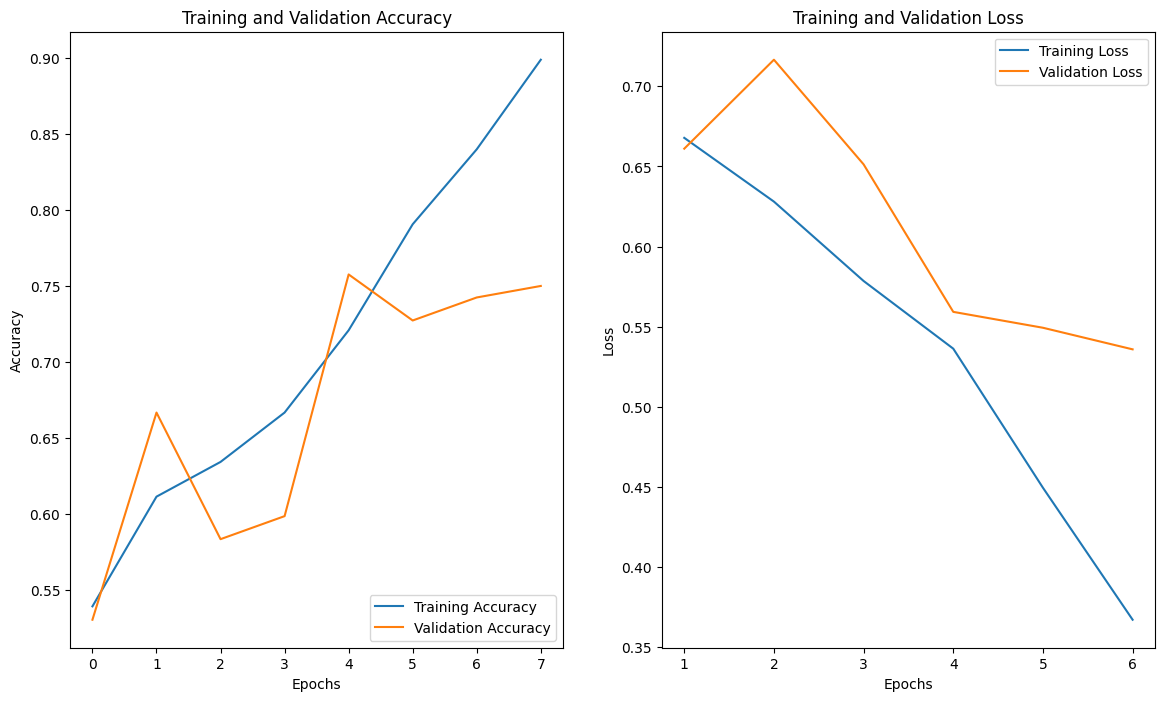

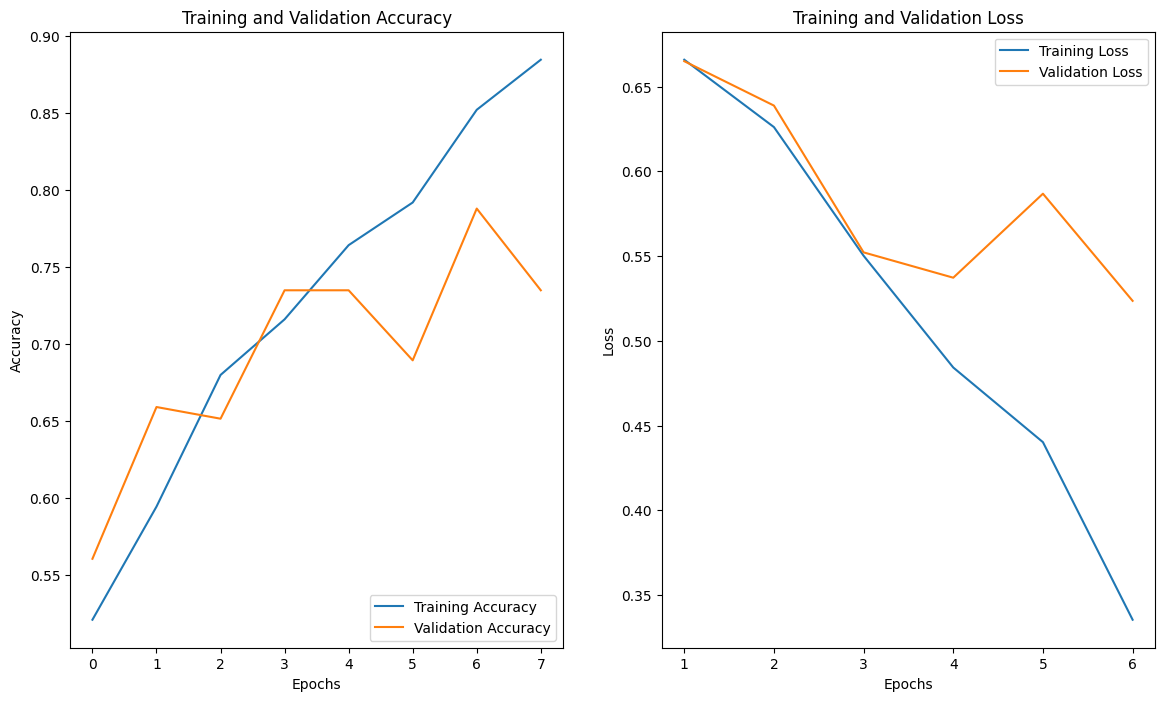

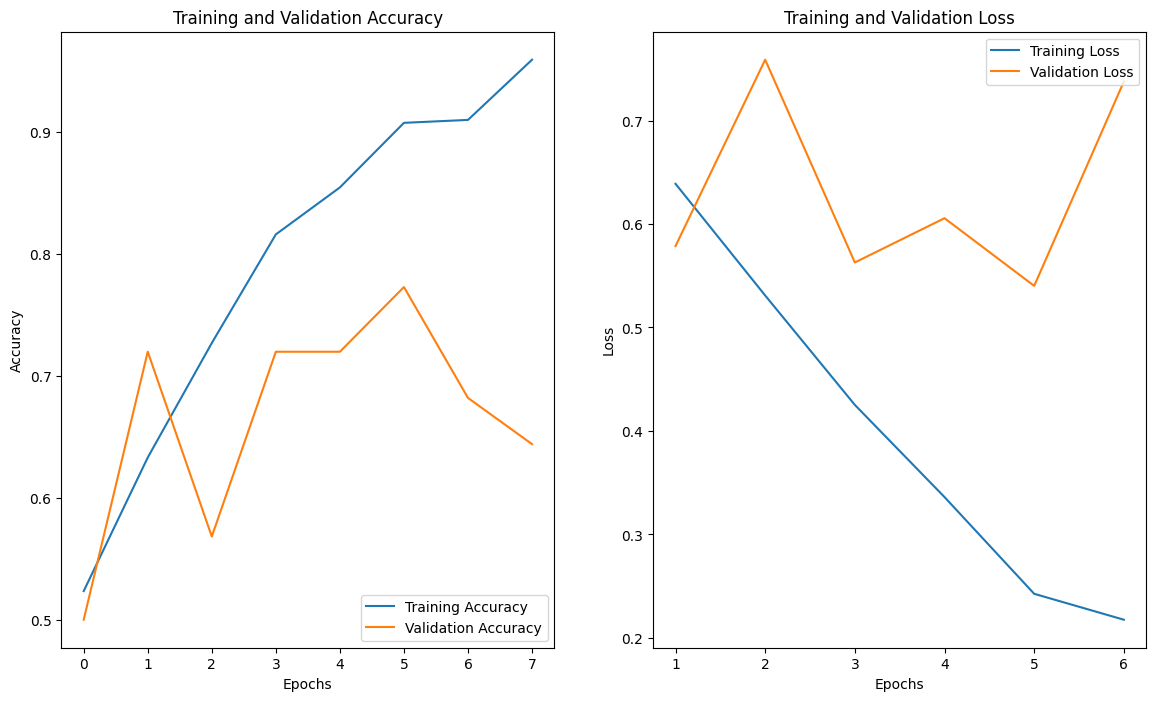

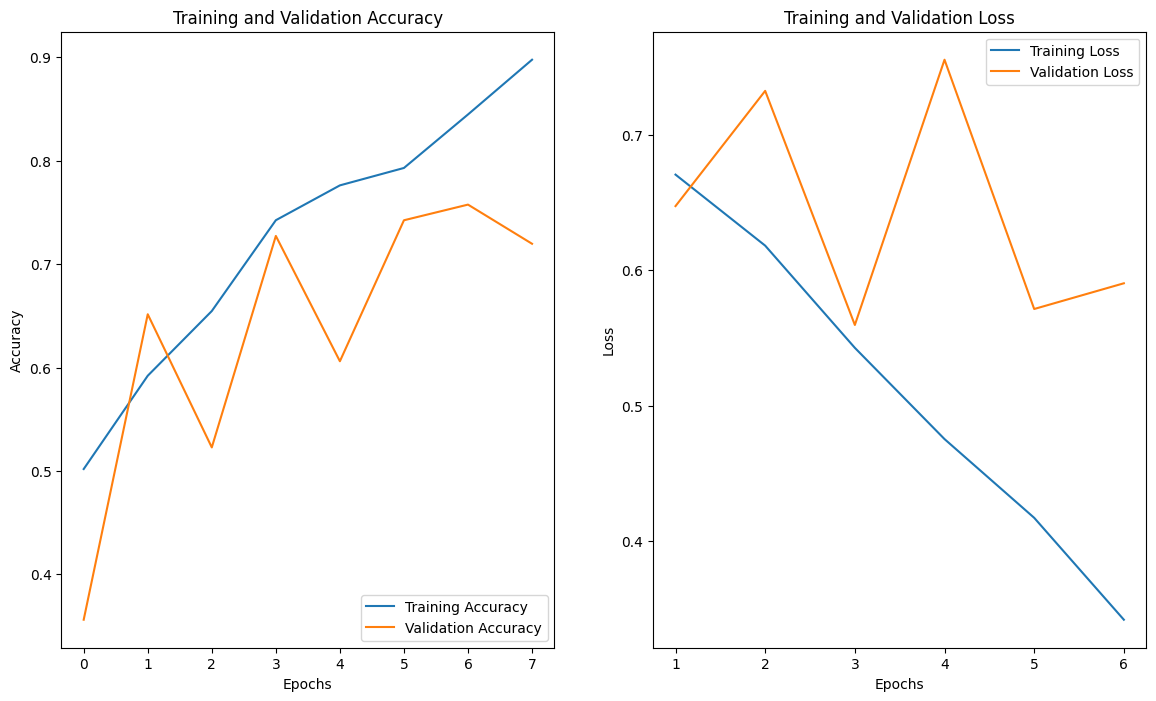

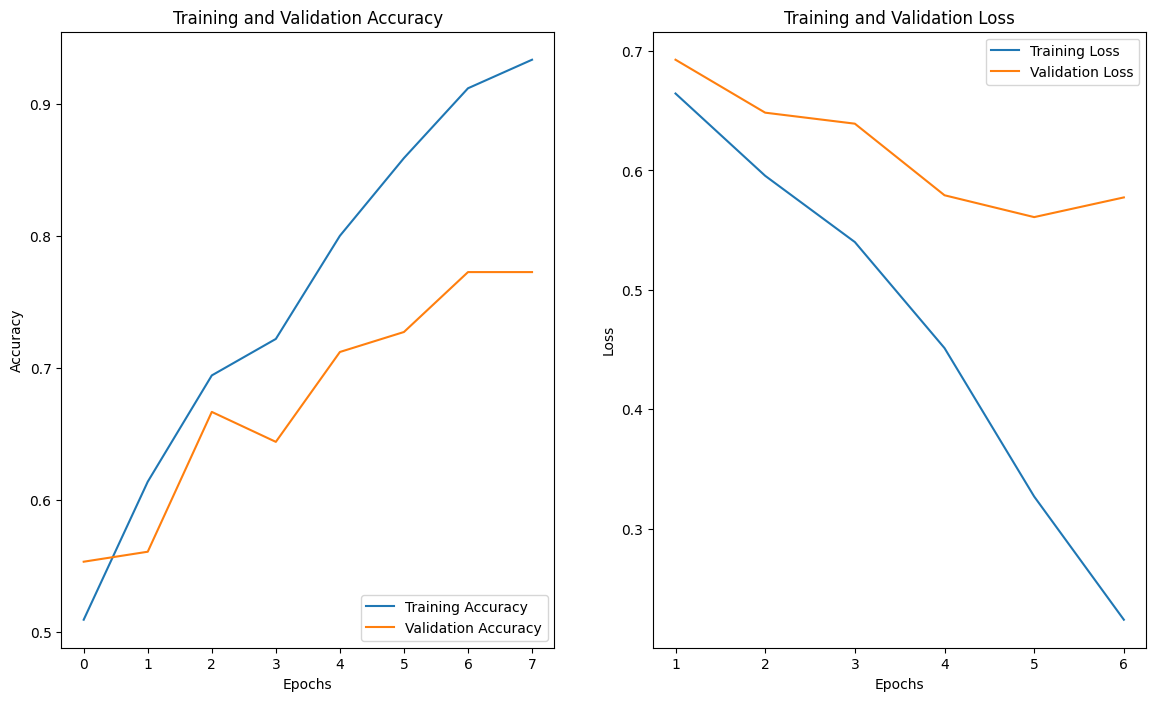

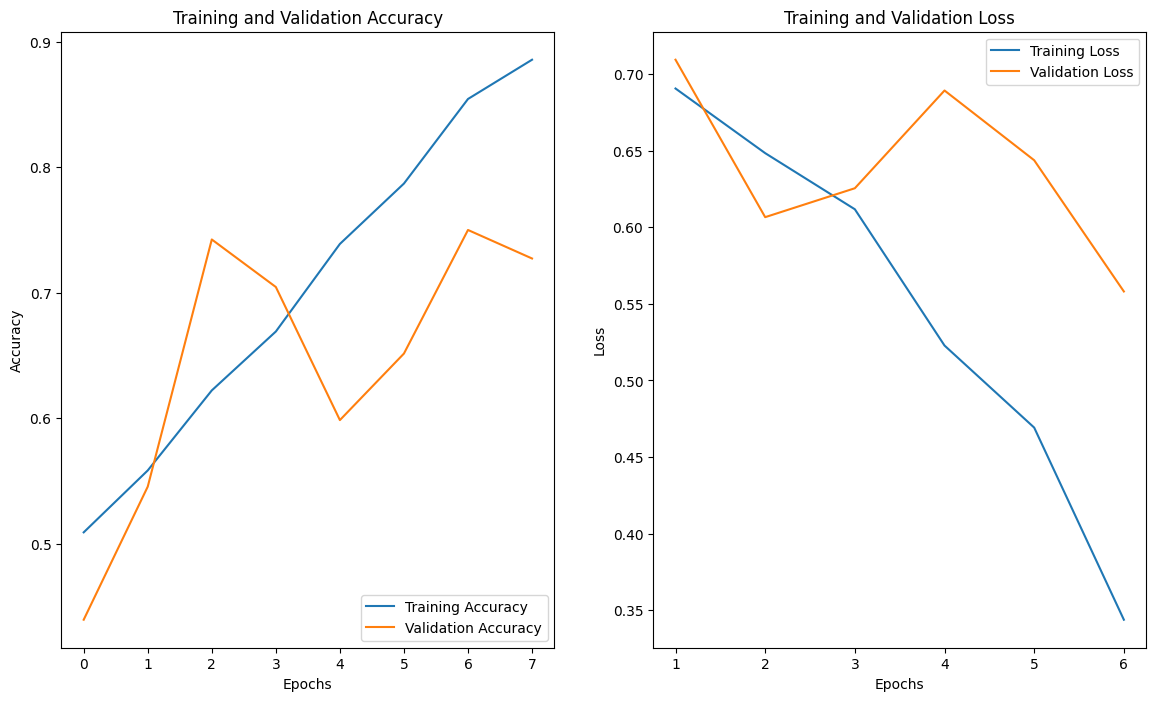

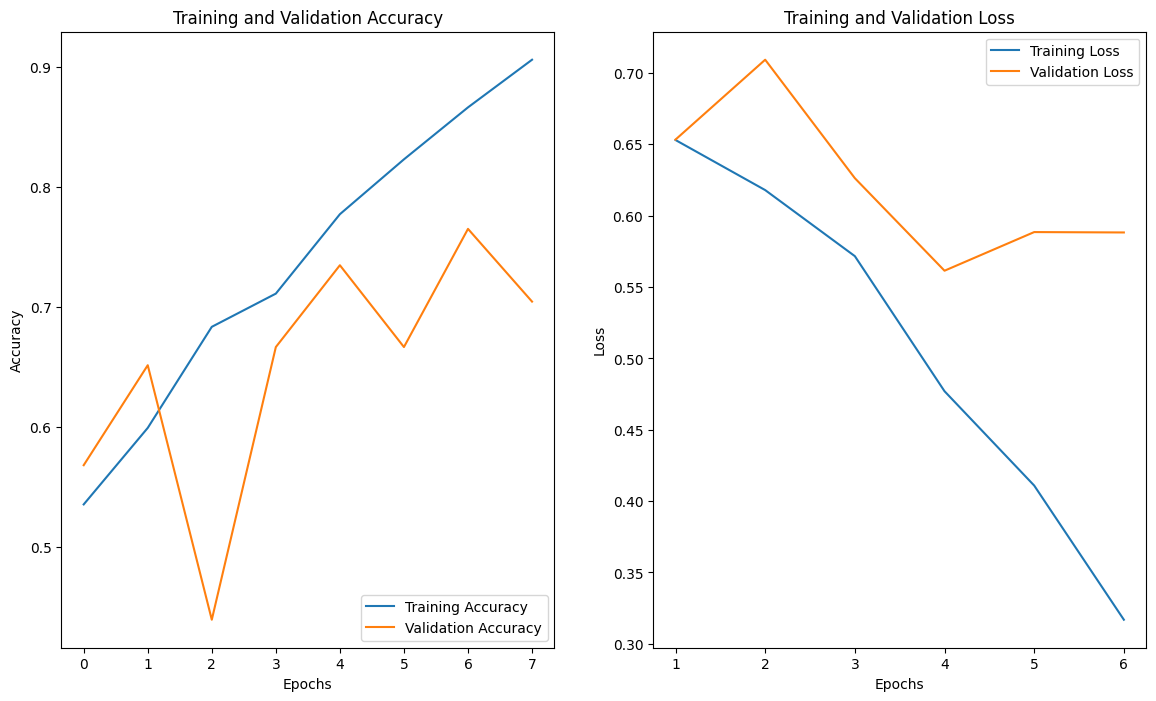

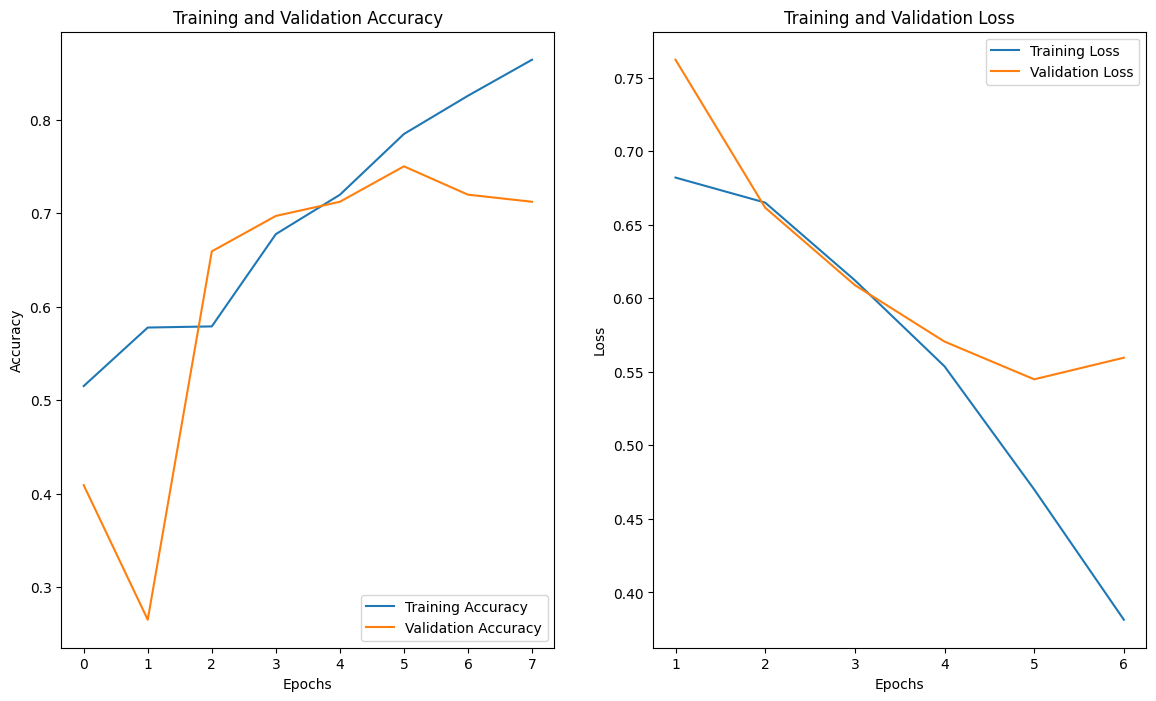

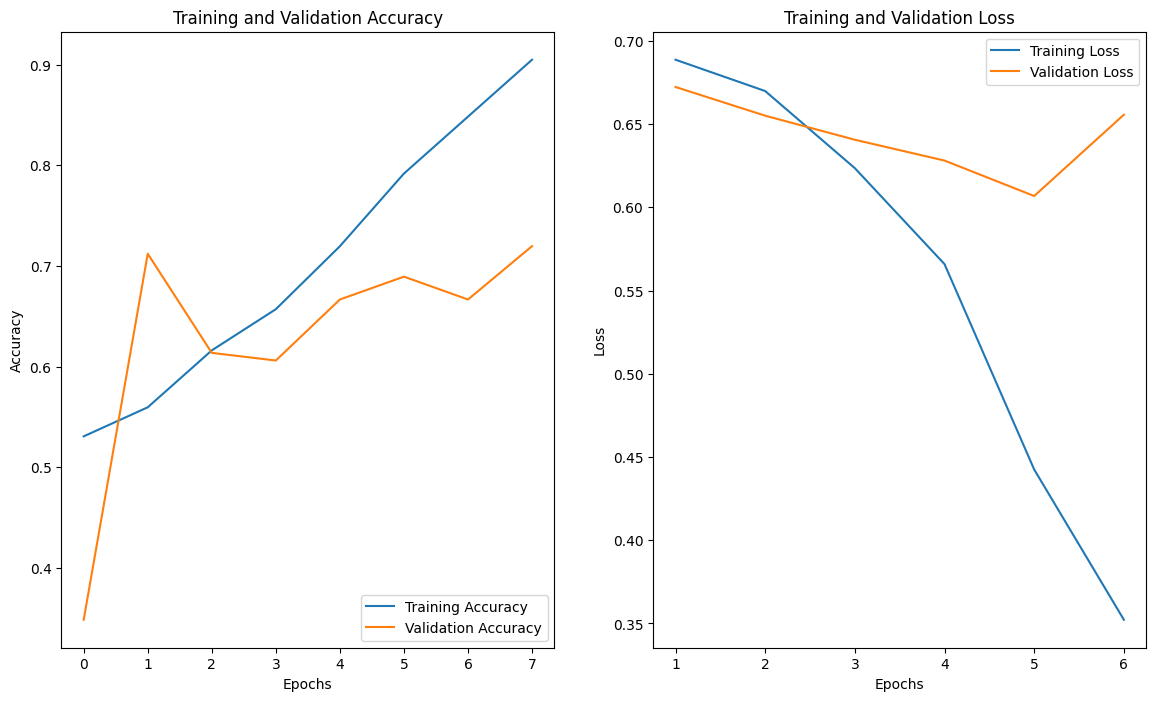

In [27]:
#for history in histories: CNN_lib.plot_train_eval(history,epochs)

In [28]:
modelos =[ load_model(pp) for pp in check_points_p]

In [29]:
loss= []
accuracy = []

for model in modelos:

    test_loss, test_accuracy = model.evaluate(X_eval,Y_eval,verbose=0) 

    loss.append(test_loss)
    accuracy.append(test_accuracy)


5/5 - 1s - loss: 0.5275 - accuracy: 0.7500 - 762ms/epoch - 152ms/step
5/5 - 1s - loss: 0.5359 - accuracy: 0.7424 - 630ms/epoch - 126ms/step
5/5 - 1s - loss: 0.5236 - accuracy: 0.7879 - 630ms/epoch - 126ms/step
5/5 - 1s - loss: 0.5402 - accuracy: 0.7727 - 612ms/epoch - 122ms/step
5/5 - 1s - loss: 0.5596 - accuracy: 0.7273 - 668ms/epoch - 134ms/step
5/5 - 1s - loss: 0.5546 - accuracy: 0.7727 - 635ms/epoch - 127ms/step
5/5 - 1s - loss: 0.5580 - accuracy: 0.7500 - 731ms/epoch - 146ms/step
5/5 - 1s - loss: 0.5614 - accuracy: 0.7348 - 632ms/epoch - 126ms/step
5/5 - 1s - loss: 0.5449 - accuracy: 0.7500 - 638ms/epoch - 128ms/step
5/5 - 1s - loss: 0.5832 - accuracy: 0.7197 - 670ms/epoch - 134ms/step


## ROC CURVE

In [30]:
roc_aucs = []

for model in modelos:

    predictions = model.predict(X_eval)

    fpr_val, tpr_val, thresholds_val = roc_curve(Y_eval, predictions)
    roc_auc_false = auc(fpr_val, tpr_val)
    roc_aucs.append(roc_auc_false)

    #CNN_lib.plot_roc_curve(fpr_val,tpr_val,roc_auc_false)


5/5 [==============================] - 1s 106ms/step


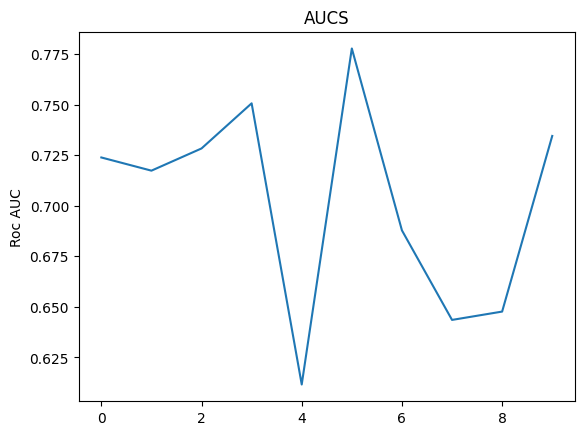

In [31]:
CNN_lib.list_plot(roc_aucs,title='AUCS',ylabel='Roc AUC')


In [32]:
print( 'AUC')

CNN_lib.stats(roc_aucs)


AUC
Valor medio:0.702
Desviación estandar:0.05
Varianza:0.003
Máximo:0.778
Mínimo:0.612
Mediana:0.721
Percentil 25:0.658
Percentil 75:0.733


In [33]:
print( 'LOSS')

CNN_lib.stats(loss)

LOSS
Valor medio:0.549
Desviación estandar:0.017
Varianza:0.0
Máximo:0.583
Mínimo:0.524
Mediana:0.55
Percentil 25:0.537
Percentil 75:0.559


In [40]:
print( 'ACCURACITY')

CNN_lib.stats(accuracy,rnd=4)

ACCURACITY
Valor medio:0.7508
Desviación estandar:0.0205
Varianza:0.0004
Máximo:0.7879
Mínimo:0.7197
Mediana:0.75
Percentil 25:0.7367
Percentil 75:0.767


#  FORECAST EVALUATION

In [35]:

predictions_raw=[]

trsh=0.35

for pred in predictions:

    if pred < trsh:predictions_raw.append(0)
    else:predictions_raw.append(1)

predictions_raw=np.array(predictions_raw)


In [36]:
conf_matrix = confusion_matrix(Y_eval, predictions_raw)

print("Matriz de Confusión:")
print(conf_matrix)

# Obtener el informe de clasificación
classification_report_str = classification_report(Y_eval, predictions_raw)
print("Informe de Clasificación:")
print(classification_report_str)



Matriz de Confusión:
[[72 32]
 [ 9 19]]
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.89      0.69      0.78       104
           1       0.37      0.68      0.48        28

    accuracy                           0.69       132
   macro avg       0.63      0.69      0.63       132
weighted avg       0.78      0.69      0.72       132



In [37]:
true_classes = Y_eval  

correctly_classified_indices = np.where(predictions_raw == true_classes)[0]
incorrectly_classified_indices = np.where(predictions_raw != true_classes)[0]

correctly_classified_video_ids = [video_id for video_id in correctly_classified_indices]
incorrectly_classified_video_ids = [video_id for video_id in incorrectly_classified_indices]

num_zeros = np.count_nonzero(Y_eval == 0)
num_ones = np.count_nonzero(Y_eval == 1)


In [38]:
correct_labels_val = [Y_eval[i] for i in correctly_classified_indices]

print(correct_labels_val)

[0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


In [39]:

print(f"OK, {len(correctly_classified_video_ids)}")
print(f"BAD, {len(incorrectly_classified_video_ids)}")
print(f'Ratio forecast: {len(correctly_classified_video_ids)/len(incorrectly_classified_video_ids)}')
print(f'Ratio labeling: {max([num_ones,num_zeros])/min([num_ones,num_zeros])}')


OK, 91
BAD, 41
Ratio forecast: 2.2195121951219514
Ratio labeling: 3.7142857142857144
